## Assignment 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
yeast = pd.read_csv('data/yeast.data', sep = '\s+', header = None)
col_names = ['v{}'.format(i) for i in range(0, 9)]
col_names.append('y') 
yeast.columns = col_names
yeast.rename(columns={yeast.columns[0]: 'Source'}, inplace = True)
yeast.head()

,Source,v1,v2,v3,v4,v5,v6,v7,v8,y
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [3]:
x = yeast.iloc[:, 1:9]
y = np.array(yeast['y']).reshape(-1, 1)

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(y)
y = y.toarray()

## Ourlier Detection

Outlier detectot to be used:
- LOF: Local Outlier Factor
- One class SVM
- Isolation Forest

In [5]:
#sns.pairplot(yeast.iloc[:,1:10], hue = 'y')
#plt.savefig('pics/pair.png')

### One class SVM

In [6]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma = 'auto')
outlier = clf.fit_predict(x)

In [7]:
pd.Series(outlier).value_counts()

 1    743
-1    741
dtype: int64

Any data labeled by -1 is treated as an outlier using the method. 

### LOF

In [8]:
from sklearn.neighbors import LocalOutlierFactor as LOF

In [9]:
lof = LOF()
outlier1 = lof.fit_predict(x)
pd.Series(outlier1).value_counts()

/Users/yry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


 1    1335
-1     149
dtype: int64

### Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest

In [11]:
clf = IsolationForest()
outlier2 = clf.fit_predict(x)
pd.Series(outlier2).value_counts()

/Users/yry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/yry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/yry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1    1335
-1     149
dtype: int64

### Remove outlier

In [12]:
x_ = x.iloc[np.where(outlier1 == 1)[0],].reset_index(drop = True)
y_ = y[np.where(outlier1 == 1)[0],]
y_.shape

(1335, 10)

## Build up ANN model.

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [35]:
scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

x_tr, x_te, y_tr, y_te = train_test_split(x_, y_,  test_size = 0.34, random_state = 256)
tr = y_tr.argmax(axis = 1)
te = y_te.argmax(axis = 1)


In [36]:
def get_err(true, pred, mode = 1):
    matrix = confusion_matrix(true, pred)
    
    if mode == 1:
        err = 1 - (matrix[0,0]+matrix[1:, 1:].sum()) / matrix.sum()
    else:
        err = 1 - (np.diag(matrix).sum()) / matrix.sum()
    return err

tt = np.random.randint(0, 7, y_tr.shape[0])

print(get_err(tr, tt), get_err(tr, tt, mode = 2))


0.3870601589103292 0.9125993189557321


In [68]:
class call_weight(keras.callbacks.Callback):
    '''
    This class is to help me track the wieght of the last layer using a 
    keras sequence
    '''
    # Def my own callback class so I can track the weight.
    def on_train_begin(self,logs = {}):
        self.weights = []
    def on_train_batch_end(self, batch, logs = {}):
        w = self.model.layers[-1].get_weights()
        w_arr =[w[1][ 1]]
        w_arr.extend(list(w[0][:,1]))
        self.weights.append(w_arr)

class call_err(keras.callbacks.Callback):
    def __init__(self, mode):
        super(call_err, self).__init__()
        self.mode = mode

    def on_train_begin(self, logs = {}):
        self.err_tr = []
        self.err_te = []
    
    def on_epoch_end(self,batch, logs = {}):
        pred_tr = self.model.predict(x_tr).argmax(axis = 1)
        pred_te = self.model.predict(x_te).argmax(axis = 1)
        err_tr = get_err(tr, pred_tr, self.mode)
        err_te = get_err(te, pred_te, self.mode)
        self.err_tr.append(err_tr)
        self.err_te.append(err_te)
    
class call_loss(keras.callbacks.Callback):
    '''
    This class is to track losses.
    '''
    def on_train_begin(self, logs = {}):
        self.losses = []

    def on_train_batch_end(self, batch,  logs = {}):
        # print(logs)
        self.losses.append(logs.get('loss'))
                                         
# Build up the sequential model.  
def MLP(hidden_layers, nodes, learning_rate = 0.1, hidden_layer = tf.nn.sigmoid, output_layer = tf.nn.sigmoid, loss = 'mse'):
    m = Sequential()
    # Add the hidden layers iteratively
    for l in range(hidden_layers):
        m.add(Dense(nodes, activation = hidden_layer, 
        kernel_initializer = tf.initializers.RandomUniform ))
    # Add the output layer.
    m.add(Dense(10,activation = output_layer, 
        kernel_initializer = tf.initializers.RandomUniform ))
    
    m.compile(optimizer = keras.optimizers.SGD(learning_rate = learning_rate), loss = loss, metrics = ['accuracy'])
    return m

In [111]:
# Initialize the model.
MLP1 = MLP(2, 3, learning_rate = 0.012)

# Initialize the trackers.
weight_tracker = call_weight()
loss_tracker = call_loss()
err_tracker = call_err(1)

MLP1.fit(x_tr,y_tr, epochs = 00, batch_size = 128,verbose = 0, callbacks = [weight_tracker, loss_tracker, err_tracker])

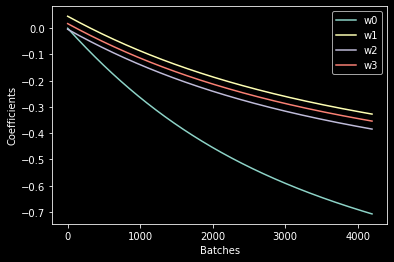

In [112]:
w = np.array(weight_tracker.weights)
w0 = w[:, 0]
w1 = w[:, 1]
w2 = w[:, 2]
w3 = w[:, 3]
plt.figure()
plt.plot(w0, label = 'w0')
plt.plot(w1, label = 'w1')
plt.plot(w2, label = 'w2')
plt.plot(w3, label = 'w3')
plt.legend()
plt.xlabel('Batches')
plt.ylabel('Coefficients')
plt.savefig('pics/weight.png')
plt.show()


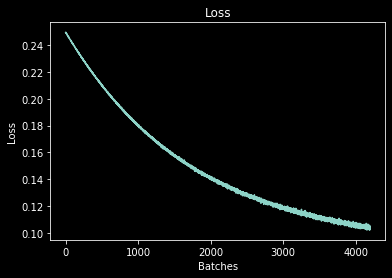

In [113]:
plt.plot(loss_tracker.losses)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss')
plt.savefig('pics/loss.png')
plt.show()

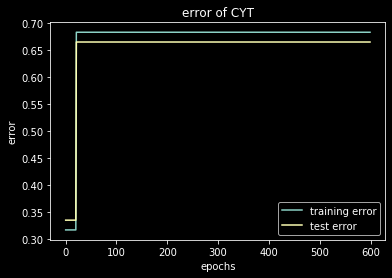

In [114]:
plt.plot(err_tracker.err_tr, label = 'training error')
plt.plot(err_tracker.err_te, label = 'test error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.title('error of CYT')
plt.legend()
plt.savefig('pics/error1')

In [109]:
err_tracker.err_tr[-1]

0.6833144154370034

In [110]:
MLP1.predict(x_te).argmax(axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Re-train ANN model with all data 

In [118]:
MLP2 = MLP(2, 3, learning_rate = 0.012)
err_tracker = call_err(1)
history= MLP2.fit(x_, y_, epochs = 200, batch_size = 128,verbose = 0, callbacks = [err_tracker])

Train on 1335 samples
Epoch 1/200
1335/1335 - 0s - loss: 0.2529 - accuracy: 0.0277
Epoch 2/200
1335/1335 - 0s - loss: 0.2519 - accuracy: 0.0277
Epoch 3/200
1335/1335 - 0s - loss: 0.2509 - accuracy: 0.3228
Epoch 4/200
1335/1335 - 0s - loss: 0.2499 - accuracy: 0.3228
Epoch 5/200
1335/1335 - 0s - loss: 0.2489 - accuracy: 0.3228
Epoch 6/200
1335/1335 - 0s - loss: 0.2479 - accuracy: 0.3228
Epoch 7/200
1335/1335 - 0s - loss: 0.2469 - accuracy: 0.3228
Epoch 8/200
1335/1335 - 0s - loss: 0.2459 - accuracy: 0.3228
Epoch 9/200
1335/1335 - 0s - loss: 0.2450 - accuracy: 0.3228
Epoch 10/200
1335/1335 - 0s - loss: 0.2440 - accuracy: 0.3228
Epoch 11/200
1335/1335 - 0s - loss: 0.2430 - accuracy: 0.3228
Epoch 12/200
1335/1335 - 0s - loss: 0.2421 - accuracy: 0.3228
Epoch 13/200
1335/1335 - 0s - loss: 0.2411 - accuracy: 0.3228
Epoch 14/200
1335/1335 - 0s - loss: 0.2402 - accuracy: 0.3228
Epoch 15/200
1335/1335 - 0s - loss: 0.2392 - accuracy: 0.3228
Epoch 16/200
1335/1335 - 0s - loss: 0.2383 - accuracy: 0.

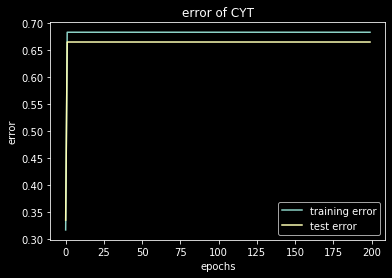

In [120]:
plt.plot(err_tracker.err_tr, label = 'training error')
plt.plot(err_tracker.err_te, label = 'test error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.title('error of CYT')
plt.legend()
plt.savefig('pics/error2')

In [122]:
weight_tracker.weights[-1]

[-0.7072653, -0.32717204, -0.38426432, -0.35385132]

## Grid search

1 3
1 6
1 9
1 12
2 3
2 6
2 9
2 12
3 3
3 6
3 9
3 12


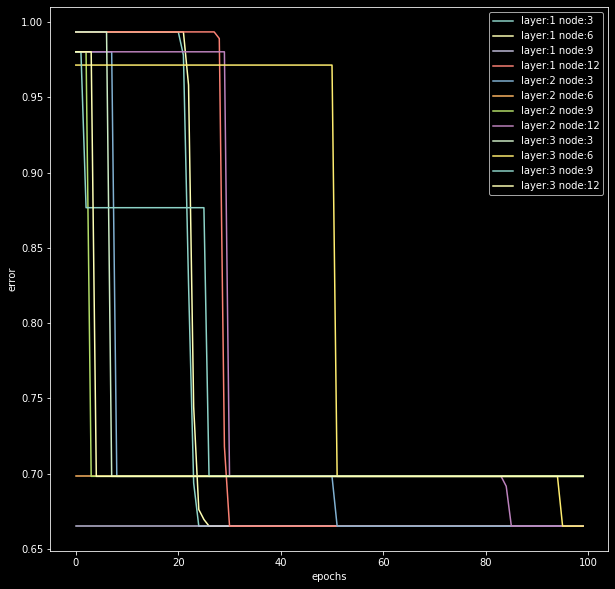

In [132]:
import time
plt.figure(figsize = (10, 10))
test_error = np.zeros((3, 4))
t = []
for i,layer in enumerate([1,2,3]):
    for k,node in enumerate([3, 6, 9, 12]):
        err_tracker = call_err(2)
        print(layer, node)
        mlp = MLP(layer, node, learning_rate = 0.005)
        start = time.clock()
        his = mlp.fit(x_, y_, epochs = 100, batch_size = 128, verbose = 0, callbacks = [err_tracker])
        end = time.clock()
        t.append(end - start)
        pred = mlp.predict(x_te).argmax(axis = 1)
        err = get_err(te, pred, mode = 2)
        test_error[i, k] = err
        plt.plot(err_tracker.err_te, label = 'layer:{} node:{}'.format(layer, node))

plt.legend()
plt.xlabel('epochs')
plt.ylabel('error')
plt.savefig('pics/grid_search1.png')
plt.show()

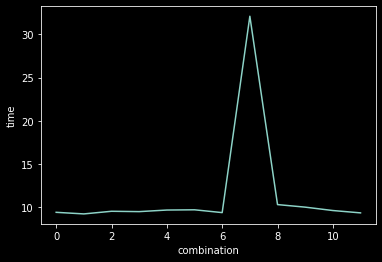

In [133]:
plt.plot(t)
plt.xlabel('combination')
plt.ylabel('time')
plt.savefig('pics/time')

## Make prediction

In [51]:
xx = np.array([0.52, 0.47, 0.52, 0.23, 0.55, 0.03, 0.52, 0.39]).reshape(1, -1)
mlp.predict(xx).argmax()

0

## Change hidden layer and activation function:

In [56]:
mlp = MLP(2, 3, learning_rate = 3, hidden_layer = tf.nn.relu, output_layer = tf.nn.softmax, loss = tf.keras.losses.categorical_crossentropy)
err_tracker = call_err()
his = mlp.fit(x_, y_, epochs = 5, batch_size = 128, verbose = 1, callbacks = [err_tracker])

- accuracy: 0.5506
Epoch 316/500
1335/1335 [==============================] - 0s 80us/sample - loss: 1.1216 - accuracy: 0.5491
Epoch 317/500
1335/1335 [==============================] - 0s 77us/sample - loss: 1.1159 - accuracy: 0.5491
Epoch 318/500
1335/1335 [==============================] - 0s 69us/sample - loss: 1.1194 - accuracy: 0.5468
Epoch 319/500
1335/1335 [==============================] - 0s 66us/sample - loss: 1.1278 - accuracy: 0.5401
Epoch 320/500
1335/1335 [==============================] - 0s 74us/sample - loss: 1.1190 - accuracy: 0.5498
Epoch 321/500
1335/1335 [==============================] - 0s 78us/sample - loss: 1.1165 - accuracy: 0.5610
Epoch 322/500
1335/1335 [==============================] - 0s 87us/sample - loss: 1.1205 - accuracy: 0.5438
Epoch 323/500
1335/1335 [==============================] - 0s 89us/sample - loss: 1.1254 - accuracy: 0.5416
Epoch 324/500
1335/1335 [==============================] - 0s 86us/sample - loss: 1.1236 - accuracy: 0.5348
Epoch 325

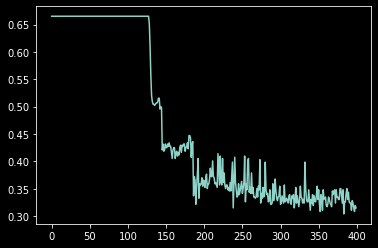

In [55]:
plt.plot(err_tracker.err_te)

In [0]:
mlp.summary()

In [124]:
import time

In [125]:
time.time()

1573119165.025816